## **DSA210 Term Project** ##

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, chi2_contingency
import statsmodels.api as sm

#### **1. Load Data and Combine Data Sets** ####

In [94]:
file_path= "DSA210_TERMPROJECT_DATA.xlsx" 
df_project = pd.read_excel(file_path)
df_project.head()

,DATE,Body Weight (kg),Body Fat Percentage (%),Daily Calorie Intake,Daily Protein Intake(g),Daily Carbohydrate Intake(g),Daily Fat Intake(g),Sleep Duration (hours),Sleep Quality,Exercise Time (minutes),Water Intake (L)
0,06/02/2025,70.80,31.50,1349.0,111.47,143.67,34.65,5.0,1,0,1.5
1,07/02/2025,70.56,31.41,1591.0,72.62,186.22,46.20,7.0,1,110,2.0
2,08/02/2025,70.46,31.35,1571.0,132.24,149.54,51.03,8.0,2,60,2.5
3,09/02/2025,70.32,31.28,1638.0,131.25,119.85,83.36,9.0,3,0,3.0
4,10/02/2025,70.23,31.22,1211.0,NaN,120.54,52.14,10.0,4,0,3.5


In [95]:
#Convert date column
df_project["DATE"] = pd.to_datetime(df_project["DATE"], dayfirst= True)

In [96]:
df_weather = pd.read_csv("istanbul_tuzla.csv")

df_weather_simple = df_weather[["datetime", "temp"]].copy()
df_weather_simple.rename(columns={"datetime": "DATE", "temp": "Temperature (°C)"}, inplace=True)

df_weather_simple["DATE"] = pd.to_datetime(df_weather_simple["DATE"] )

df = pd.merge(df_project, df_weather_simple, on="DATE", how="left")

In [97]:
df.head()

,DATE,Body Weight (kg),Body Fat Percentage (%),Daily Calorie Intake,Daily Protein Intake(g),Daily Carbohydrate Intake(g),Daily Fat Intake(g),Sleep Duration (hours),Sleep Quality,Exercise Time (minutes),Water Intake (L),Temperature (°C)
0,2025-02-06,70.80,31.50,1349.0,111.47,143.67,34.65,5.0,1,0,1.5,2.8
1,2025-02-07,70.56,31.41,1591.0,72.62,186.22,46.20,7.0,1,110,2.0,3.0
2,2025-02-08,70.46,31.35,1571.0,132.24,149.54,51.03,8.0,2,60,2.5,3.9
3,2025-02-09,70.32,31.28,1638.0,131.25,119.85,83.36,9.0,3,0,3.0,3.9
4,2025-02-10,70.23,31.22,1211.0,NaN,120.54,52.14,10.0,4,0,3.5,3.4


#### **2. Data Cleaning** ####

In [98]:
#Check missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 DATE                             0
Body Weight (kg)                 0
Body Fat Percentage (%)          0
Daily Calorie Intake             7
Daily Protein Intake(g)         10
Daily Carbohydrate Intake(g)     9
Daily Fat Intake(g)             10
Sleep Duration (hours)           6
Sleep Quality                    0
Exercise Time (minutes)          0
Water Intake (L)                 5
Temperature (°C)                10
dtype: int64


In [99]:
# Fill missing values with column means , mean is valid because calorie and water columns has NaN values 
df.fillna(df.mean(numeric_only=True), inplace=True)

#### **3. Feature Engineering** ####

In [100]:
# Daily change in body fat percentage
df["Fat % Change"] = df["Body Fat Percentage (%)"].diff()
# Daily change in body weight
df["Weight Change"] = df["Body Weight (kg)"].diff()
# Calculate calorie deficit 
df["Calorie Deficit (kcal)"] = 2300 - (df["Daily Calorie Intake"] - df["Exercise Time (minutes)"] * 4)
# Add a column for protein ratio (protein intake / total calories)
df["Protein Ratio"] = df["Daily Protein Intake(g)"] / df["Daily Calorie Intake"]


#### **4.Summary statistics to get a general idea:** ####

In [101]:
df.describe()

,DATE,Body Weight (kg),Body Fat Percentage (%),Daily Calorie Intake,Daily Protein Intake(g),Daily Carbohydrate Intake(g),Daily Fat Intake(g),Sleep Duration (hours),Sleep Quality,Exercise Time (minutes),Water Intake (L),Temperature (°C),Fat % Change,Weight Change,Calorie Deficit (kcal),Protein Ratio
count,104,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,103.000000,103.000000,104.000000,104.000000
mean,2025-03-29 12:00:00,66.698173,28.461827,1502.103093,86.547021,162.975684,51.922553,7.581633,2.634615,46.730769,2.463636,10.431915,-0.055049,-0.050485,984.819984,0.058460
min,2025-02-06 00:00:00,63.600000,25.830000,899.000000,31.630000,90.050000,25.280000,5.000000,1.000000,0.000000,1.500000,-0.400000,-0.420000,-0.400000,280.000000,0.022214
25%,2025-03-03 18:00:00,64.900000,27.015000,1350.000000,71.280000,142.495000,45.150000,7.000000,1.000000,0.000000,2.000000,7.050000,-0.090000,-0.200000,806.750000,0.046759
50%,2025-03-29 12:00:00,66.555000,28.570000,1466.500000,85.890000,155.950000,51.922553,7.581633,2.500000,45.000000,2.500000,10.431915,-0.060000,-0.090000,970.000000,0.057590
75%,2025-04-24 06:00:00,68.392500,29.865000,1638.250000,106.580000,166.000000,56.000000,8.125000,4.000000,90.000000,3.000000,13.825000,-0.060000,0.100000,1154.000000,0.069749
max,2025-05-20 00:00:00,70.800000,31.500000,2500.000000,150.000000,340.000000,87.020000,10.000000,5.000000,120.000000,3.500000,22.500000,0.350000,0.430000,1456.000000,0.115385
std,NaN,2.021799,1.663341,255.509941,24.619254,41.308010,11.998740,1.373631,1.379867,46.450565,0.617300,5.164991,0.119163,0.210887,237.882323,0.017308


### **5.Data Visualization** ###

**Correlation Matrix**

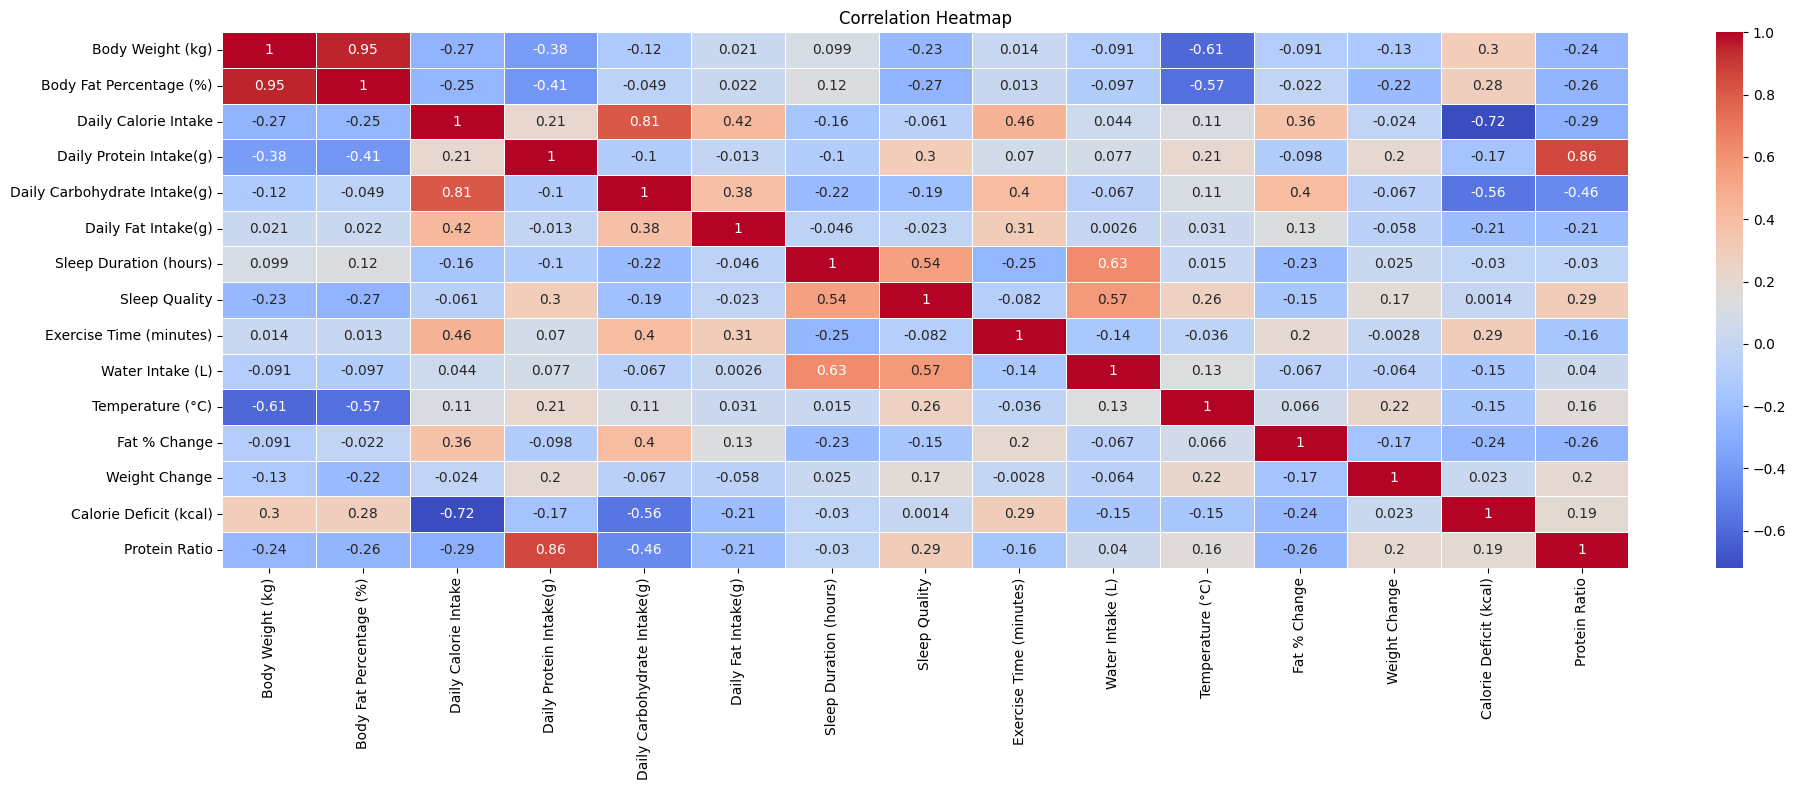

In [102]:
plt.figure(figsize=(20, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

➡️ **Body Weight** and **Body Fat %** were highly correlated (r = 0.95), indicating that reductions in weight strongly aligned with reductions in fat mass.

➡️ Calorie intake and calorie deficit show a strong negative correlation (-0.72), highlighting the direct impact of calorie intake on energy balance.


**Time‑series Plot: Body Weight & Body Fat %**

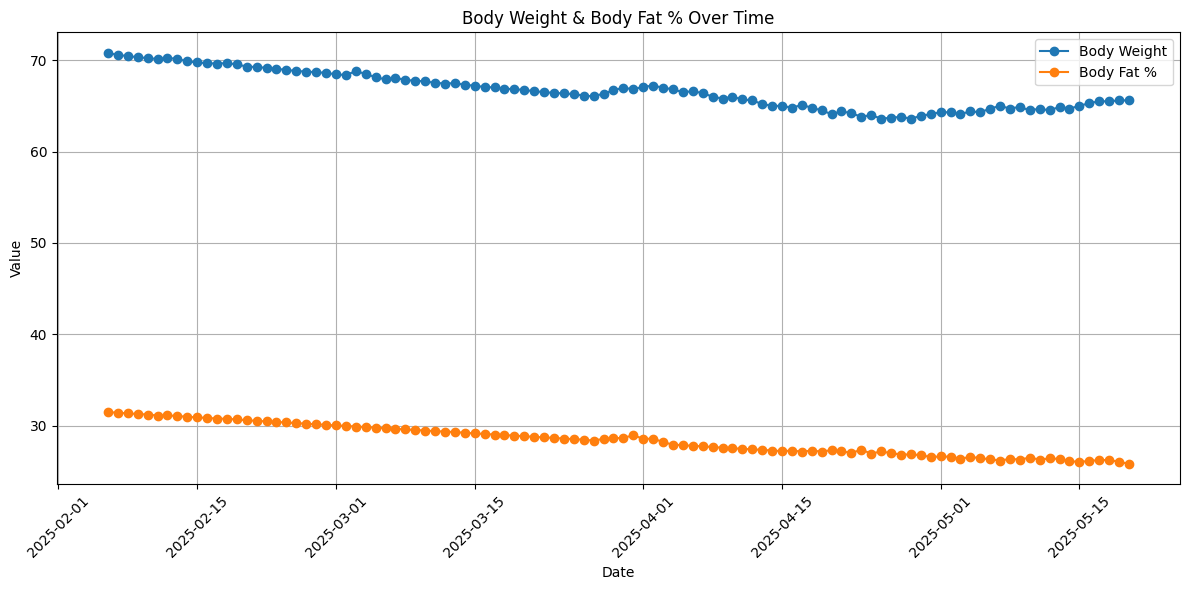

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(df["DATE"], df["Body Weight (kg)"], label="Body Weight", marker="o")
plt.plot(df["DATE"], df["Body Fat Percentage (%)"], label="Body Fat %", marker="o")
plt.title("Body Weight & Body Fat % Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Both body weight and body fat percentage showed a steady decline over the 4-month period, suggesting consistent progress in fat reduction and weight loss.

**Boxplots: Daily Calorie & Protein Intake Distributions**

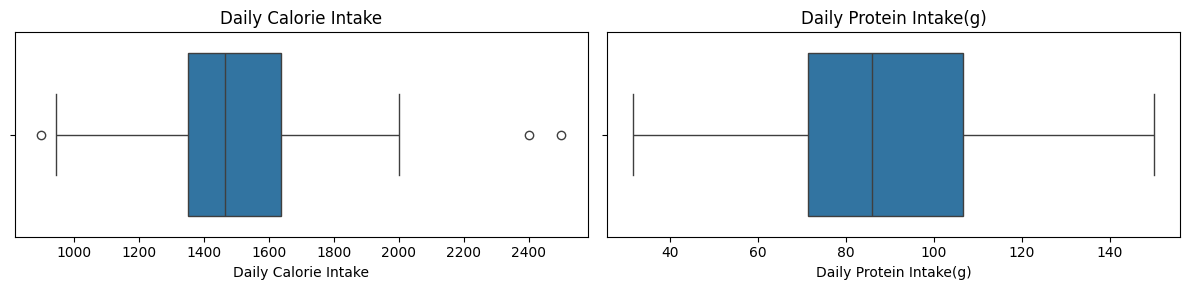

In [104]:
cols = ["Daily Calorie Intake", "Daily Protein Intake(g)"]
fig, axes = plt.subplots(1, 2, figsize=(12, 3))  
for ax, col in zip(axes.flatten(), cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

📊 Daily Calorie Intake is mostly centered around 1400–1700 kcal, with a few higher outliers above 2300 kcal, likely due to occasional surplus days.

✅Daily Protein Intake shows a relatively balanced distribution between 60–130g, with no major outliers, indicating stable protein habits.

**Scatterplots with Regression Lines: Visualizing the relationships between key predictors and body composition metrics**


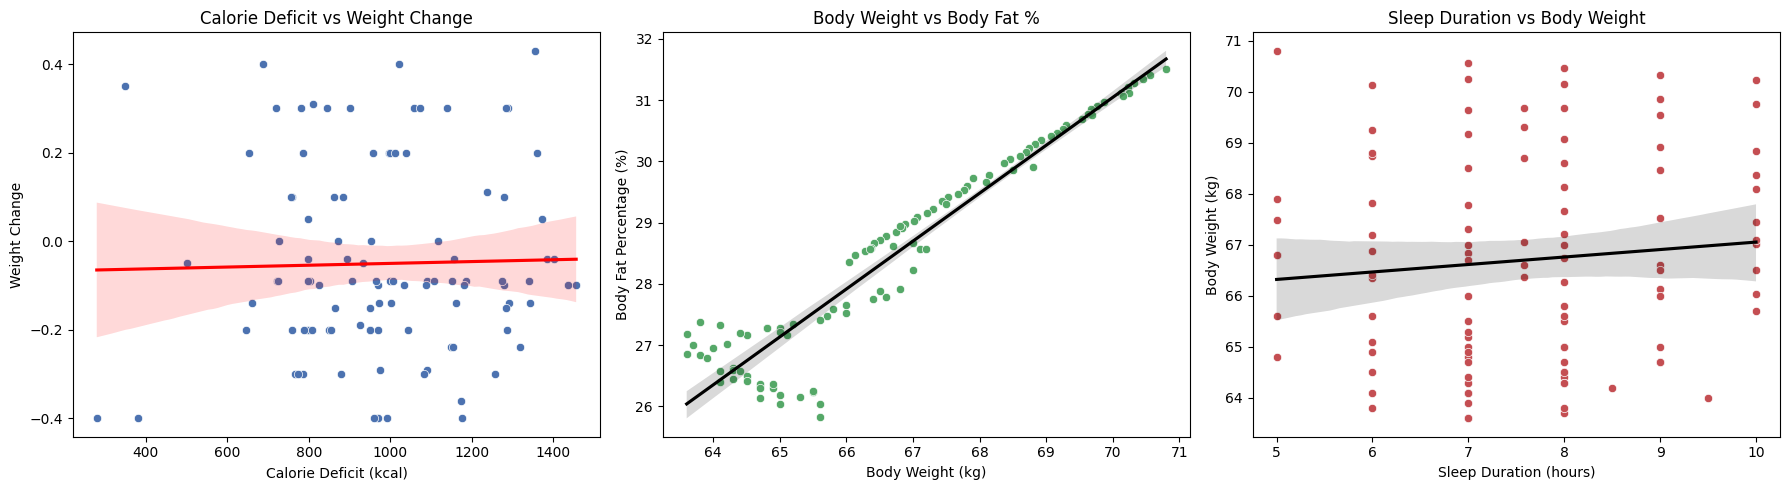

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

# Plot 1: Calorie Deficit vs Weight Change
sns.scatterplot(x="Calorie Deficit (kcal)", y="Weight Change", data=df, ax=axes[0], color="#4C72B0")
sns.regplot(x="Calorie Deficit (kcal)", y="Weight Change", data=df, ax=axes[0], scatter=False, color="red")
axes[0].set_title("Calorie Deficit vs Weight Change")

# Plot 2: Body Weight vs Body Fat %
sns.scatterplot(x="Body Weight (kg)", y="Body Fat Percentage (%)", data=df, ax=axes[1], color="#55A868")
sns.regplot(x="Body Weight (kg)", y="Body Fat Percentage (%)", data=df, ax=axes[1], scatter=False, color="black")
axes[1].set_title("Body Weight vs Body Fat %")

# Plot 3: Sleep Duration vs Body Weight
sns.scatterplot(x="Sleep Duration (hours)", y="Body Weight (kg)", data=df, ax=axes[2], color="#C44E52")
sns.regplot(x="Sleep Duration (hours)", y="Body Weight (kg)", data=df, ax=axes[2], scatter=False, color="black")
axes[2].set_title("Sleep Duration vs Body Weight")

plt.tight_layout()
plt.show()

➡️ **1. Calorie Deficit vs Weight Change**  
A weak positive trend is visible, but the wide confidence interval suggests low predictive power. This indicates that same-day calorie deficit does not reliably predict immediate weight change.

➡️ **2. Body Weight vs Body Fat %**  
A very strong linear correlation is evident (r ≈ 0.98), showing that reductions in weight closely mirror reductions in body fat percentage.

➡️ **3. Sleep Duration vs Body Weight**  
There is no significant trend, indicating sleep duration alone is not strongly associated with variations in body weight in this dataset.


**Boxplots: Calorie Group vs Body Weight**

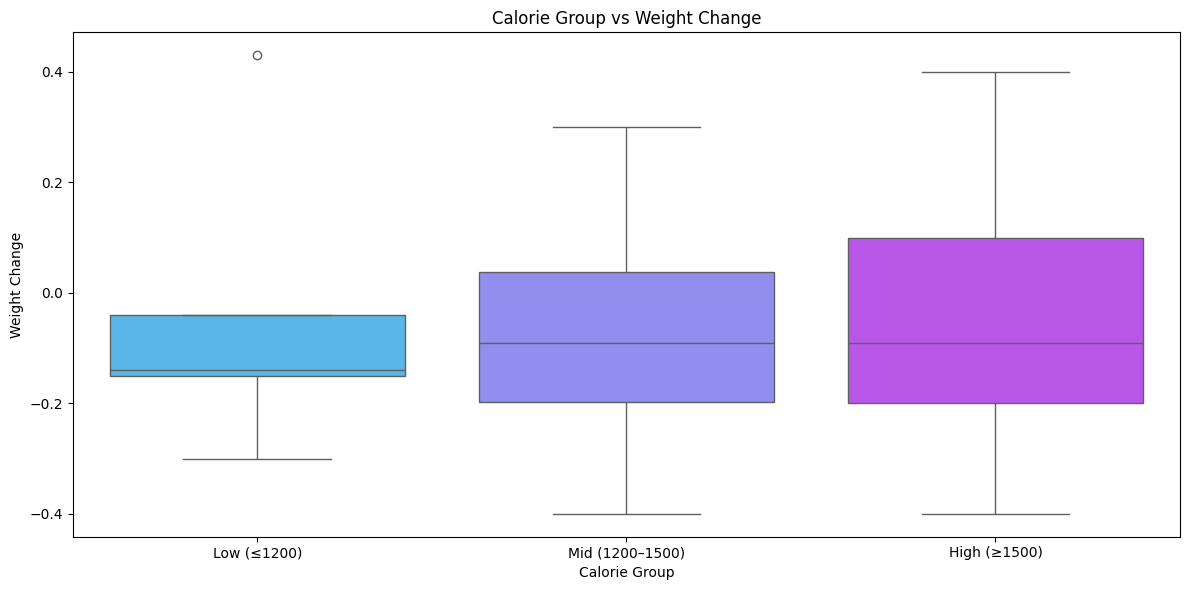

In [106]:
cal_groups = pd.cut(df["Daily Calorie Intake"],bins=[0, 1200, 1500, 10000],labels=["Low (≤1200)", "Mid (1200–1500)", "High (≥1500)"])

df["Calorie Group"] = cal_groups

plt.figure(figsize=(12, 6))
sns.boxplot(x="Calorie Group", y="Weight Change", hue="Calorie Group", data=df, palette="cool", legend=False)
plt.title("Calorie Group vs Weight Change")
plt.tight_layout()
plt.show()

➡️ Low Calorie Group (≤1200 kcal)
This group did not consistently result in weight loss. Some days even showed weight gain, indicating that short-term restriction does not guarantee immediate fat loss.

➡️ Mid Calorie Group (1200–1500 kcal)
Showed the widest range of weight fluctuations, including both loss and gain. This suggests that other variables (like exercise/sleep) may play a greater role than calorie level alone in this range.

➡️ High Calorie Group (≥1500 kcal)
Surprisingly, this group also included instances of weight loss, possibly due to increased physical activity, higher metabolism, or delayed caloric impact.

**Daily Calorie Intake vs Exercise Duration**

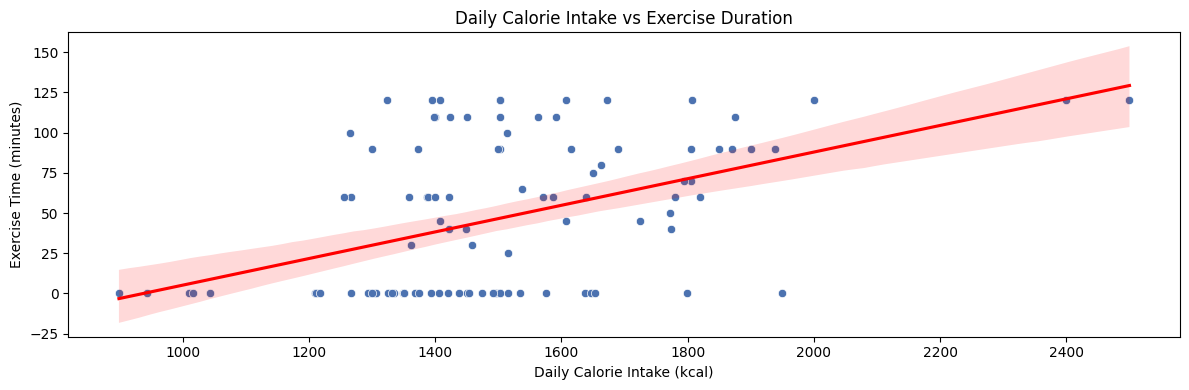

In [107]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x="Daily Calorie Intake", y="Exercise Time (minutes)", data=df, color="#4C72B0")
sns.regplot(x="Daily Calorie Intake", y="Exercise Time (minutes)", data=df, scatter=False, color="red")
plt.title("Daily Calorie Intake vs Exercise Duration")
plt.xlabel("Daily Calorie Intake (kcal)")
plt.ylabel("Exercise Time (minutes)")
plt.tight_layout()
plt.show()

📊 This plot shows that higher daily calorie intake is generally associated with longer exercise durations.

✅ This observation helps explain why weight loss can still occur on high-calorie days—because they often coincide with more exercise, offsetting the increased intake.

**Boxplots: Calorie Deficit Quartiles vs Fat Loss**

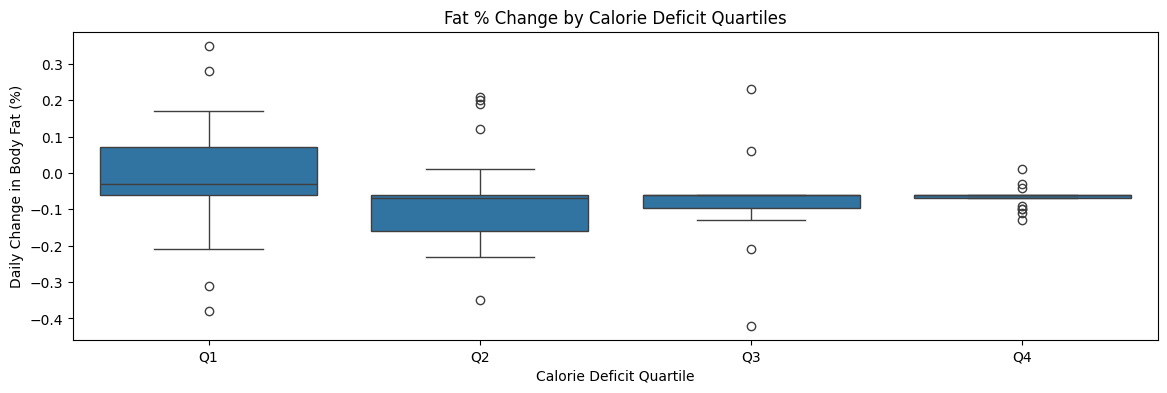

In [108]:
df["Deficit_Quartile"] = pd.qcut(df["Calorie Deficit (kcal)"], 4, labels=["Q1", "Q2", "Q3", "Q4"])

plt.figure(figsize=(14,4))
sns.boxplot(x="Deficit_Quartile", y="Fat % Change", data=df)
plt.title("Fat % Change by Calorie Deficit Quartiles")
plt.xlabel("Calorie Deficit Quartile")
plt.ylabel("Daily Change in Body Fat (%)")
plt.show()


➡️ The plot shows that individuals in the highest calorie deficit quartile (Q4) experienced the most consistent fat percentage reductions, with minimal variability.

➡️ In contrast, Q1 (lowest deficit) showed the widest range of changes, including both increases and decreases in body fat.

✅ This suggests that higher and sustained deficits may not only reduce fat more reliably but also stabilize day-to-day fluctuations, my second hypothesis is also about this.

### **6. Hypothesis Testing** ###

**HYPOTHESIS 1: Calories vs Body Weight**
 
**H₀: Total daily caloric intake has no significant relationship with overall body weight.**

**H₁: Higher total caloric intake is significantly associated with increased body weight.**

**Method: Two sample t test with 0.05 significance level**

In [109]:
# Add next-day weight column
df["Weight_next"] = df["Body Weight (kg)"].shift(-1)

print("H2 | Calories vs Body Weight")

hi_mask = df["Daily Calorie Intake"] > 1700
lo_mask = df["Daily Calorie Intake"] < 1700

hi_w_next = df.loc[hi_mask, "Weight_next"].dropna()
lo_w_next = df.loc[lo_mask, "Weight_next"].dropna()

t_stat, p_val = ttest_ind(hi_w_next, lo_w_next, equal_var=False)

print(f"t-test  (Calories >1700 vs <1700, next-day weight): "
      f"t = {t_stat:.2f},  p = {p_val:.4f}")

if p_val < 0.05:
    print("Since p < 0.05, we reject the null hypothesis. Daily calorie intake significantly affects next-day weight.")
else:
    print("Since p ≥ 0.05, we fail to reject the null hypothesis — no significant difference found.")


H2 | Calories vs Body Weight
t-test  (Calories >1700 vs <1700, next-day weight): t = -1.32,  p = 0.1948
Since p ≥ 0.05, we fail to reject the null hypothesis — no significant difference found.


**HYPOTHESIS 2: Deficit vs Fat % Change**

**H₀: A daily caloric deficit does not significantly influence reductions in body fat percentage.**

**H₁: Consistent caloric deficits are significantly associated with reductions in body fat percentage.**

**Method: Pearson correlation with 0.05 significance level**

In [110]:
print("H2 | Calorie Deficit vs Fat % Change")

pear_r2, p2 = pearsonr(df["Calorie Deficit (kcal)"], df["Fat % Change"].fillna(0))
print(f"Pearson r = {pear_r2:.3f}  p = {p2:.12f}")

if p2 < 0.05:
    print("Since p < 0.05, we reject the null hypothesis. Consistent caloric deficits significantly influence fat % change.")
else:
    print("Since p ≥ 0.05, we fail to reject the null hypothesis — no significant relationship found.")

H2 | Calorie Deficit vs Fat % Change
Pearson r = -0.240  p = 0.014252170720
Since p < 0.05, we reject the null hypothesis. Consistent caloric deficits significantly influence fat % change.


**HYPOTHESIS 3: Protein Ratio vs Body Fat**

**H₀: The proportion of protein intake (relative to total calories) has no significant effect on body fat percentage reduction.**

**H₁: A higher proportion of protein intake is significantly associated with greater reductions in body fat percentage.**

**Method: Two sample t test with 0.05 significance level**

In [111]:
print("H3 | Protein Ratio vs Body Fat %")
prot_ratio = (df["Daily Protein Intake(g)"]*4) / df["Daily Calorie Intake"]
df["Protein Ratio"] = prot_ratio

hp = df[df["Protein Ratio"] > 0.30]["Body Fat Percentage (%)"]
lp = df[df["Protein Ratio"] < 0.18]["Body Fat Percentage (%)"]

t3, p3b = ttest_ind(hp, lp, equal_var=False)
print(f"t‑test (high vs low protein ratio): t = {t3:.2f}, p = {p3b:.4f}")

if p3b < 0.05:
    print("Since p < 0.05, we reject the null hypothesis — protein ratio significantly affects body fat %.")
else:
    print("Since p ≥ 0.05, we fail to reject the null hypothesis — no significant correlation found.")


H3 | Protein Ratio vs Body Fat %
t‑test (high vs low protein ratio): t = -2.71, p = 0.0112
Since p < 0.05, we reject the null hypothesis — protein ratio significantly affects body fat %.


**HYPOTHESIS 4: Sleep Quality vs Fat‑Loss Success**

**H₀: Sleep duration and sleep quality have no significant influence on body fat percentage.**

**H₁: Longer sleep duration and better sleep quality is significantly associated with greater reductions in body fat percentage.**

**Method: Pearson correlation for sleep duration; Chi-square test for sleep quality. Significance level = 0.05.**

In [112]:
print("H4 | Sleep Duration vs Fat % Change")

mask = df["Sleep Duration (hours)"].notna() & df["Fat % Change"].notna()
r_sleep, p_sleep = pearsonr(df.loc[mask, "Sleep Duration (hours)"], df.loc[mask, "Fat % Change"])

print(f"Pearson r = {r_sleep:.3f}, p = {p_sleep:.4f}")

if p_sleep < 0.05:
    print("Since p < 0.05, we reject the null. Sleep duration significantly influences fat % change.")
else:
    print("Since p ≥ 0.05, we fail to reject the null — no significant relationship found.")

print()
print("H4 | Sleep Quality (Good vs Poor) vs Fat‑Loss Success")

df["Sleep Category"] = df["Sleep Quality"].apply(lambda x: "Good" if x >= 4 else ("Poor" if x <= 2 else "Mid"))

fat_success = df["Fat % Change"].apply(lambda x: 1 if x < 0 else 0)

df["Fat Success"] = fat_success

contingency = pd.crosstab(df["Sleep Category"], df["Fat Success"])

chi2, p_chi, dof, exp = chi2_contingency(contingency)
print(f"Chi‑square = {chi2:.2f}, p = {p_chi:.4f}")

if p_chi < 0.05:
    print("Since p < 0.05, we reject the null. Sleep quality and fat-loss success are associated.")
else:
    print("Since p ≥ 0.05, we fail to reject the null — no significant association found.")

H4 | Sleep Duration vs Fat % Change
Pearson r = -0.226, p = 0.0220
Since p < 0.05, we reject the null. Sleep duration significantly influences fat % change.

H4 | Sleep Quality (Good vs Poor) vs Fat‑Loss Success
Chi‑square = 1.57, p = 0.4557
Since p ≥ 0.05, we fail to reject the null — no significant association found.


### **Machine Learning Techniques**

**Method: To predict Weight Change based on daily habits, I applied multiple regression models including Linear Regression, Decision Tree, and Random Forest with different hyperparameters using a grid search approach. Evaluated each model based on R² and Mean Squared Error (MSE) to identify the best-performing model for predicting weight change.**

**Regression: Predicting Weight Change**



📊 Model Comparison Results (sorted by R²):


,Model and Parameters,MSE,R²
0,Linear Regression | {'fit_intercept': False},0.0354,-0.4175
1,Linear Regression | {'fit_intercept': True},0.0375,-0.5021
2,"Random Forest | {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}",0.0380,-0.5236
3,"Random Forest | {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}",0.0391,-0.5642
4,"Random Forest | {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}",0.0392,-0.5718
5,"Random Forest | {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}",0.0398,-0.5923
6,"Random Forest | {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}",0.0398,-0.5953
7,"Random Forest | {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}",0.0413,-0.6542
8,"Random Forest | {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}",0.0415,-0.6636
9,"Random Forest | {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}",0.0418,-0.6735



🏆 Best Model: Linear Regression | {'fit_intercept': False} with R² = -0.4175


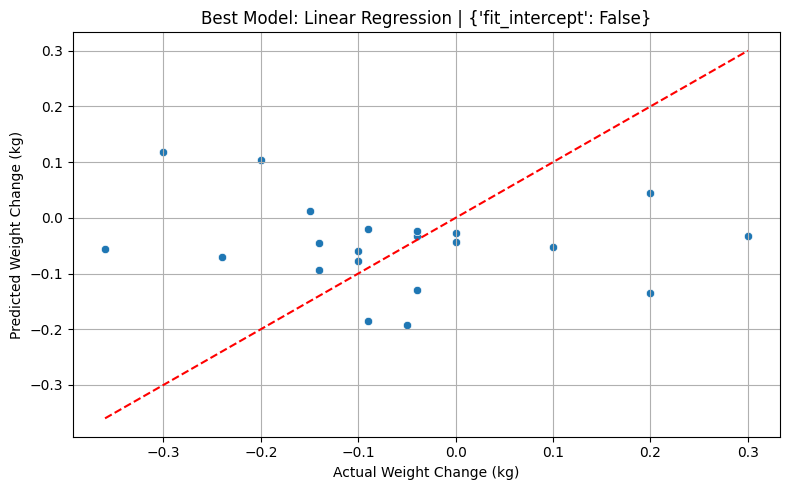

In [ ]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import display
from sklearn.preprocessing import StandardScaler

features = [
    'Daily Calorie Intake',
    'Daily Protein Intake(g)',
    'Daily Carbohydrate Intake(g)',
    'Daily Fat Intake(g)',
    'Sleep Duration (hours)',
    'Exercise Time (minutes)',
    'Temperature (°C)'
]
target = 'Weight Change'

X = df[features]
y = df[target]

data_clean = pd.concat([X, y], axis=1).dropna()
X = data_clean[features]
y = data_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    "Linear Regression": [
        {"fit_intercept": [True, False]}
    ],
    "Decision Tree": [
        {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]}
    ],
    "Random Forest": [
        {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None], "min_samples_split": [2, 5]}
    ]
}

models = {
    "Linear Regression": LinearRegression,
    "Decision Tree": DecisionTreeRegressor,
    "Random Forest": RandomForestRegressor
}

results_detailed = {}

for model_name, param_list in param_grid.items():
    for params in ParameterGrid(param_list):
        model = models[model_name](**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        key = f"{model_name} | {params}"
        results_detailed[key] = {'MSE': mse, 'R²': r2}

results_df = pd.DataFrame(results_detailed).T.reset_index()
results_df.columns = ['Model and Parameters', 'MSE', 'R²']
results_df = results_df.round(4)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print("\n📊 Model Comparison Results (sorted by R²):")
results_df_sorted = results_df.sort_values('R²', ascending=False).reset_index(drop=True)
display(results_df_sorted.head(10))

best_row = results_df_sorted.loc[0]
best_model_key = best_row['Model and Parameters']
best_model_name = best_model_key.split('|')[0].strip()
best_model_params = eval(best_model_key.split('|')[1].strip())

print(f"\n🏆 Best Model: {best_model_key} with R² = {best_row['R²']}")

best_model = models[best_model_name](**best_model_params)
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=best_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Best Model: {best_model_name} | {best_model_params}")
plt.xlabel("Actual Weight Change (kg)")
plt.ylabel("Predicted Weight Change (kg)")
plt.grid(True)
plt.tight_layout()
plt.show()


📊 The best R² value obtained among all models and parameter combinations was -0.4175, which indicates a poor model fit. This result was expected, as weight fluctuations are not always immediately observable on a single day. Therefore, a single-day prediction model may not effectively capture the underlying patterns. Given this limitation, the analysis will proceed with modeling weight change over a 7-day period, where trends may be more prominent and the impact of daily habits more measurable.

#### **Identify the best model for the 7-day weight change prediction**


📊 Top 10 Models Results (sorted by R²):


,Model and Parameters,MSE,R²
0,"Random Forest | {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}",0.2836,0.3098
1,"Random Forest | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}",0.2858,0.3044
2,"Random Forest | {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}",0.2863,0.3033
3,"Random Forest | {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",0.2874,0.3006
4,"Random Forest | {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}",0.2899,0.2945
5,"Random Forest | {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}",0.2941,0.2843
6,"Random Forest | {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}",0.2943,0.2839
7,"Random Forest | {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}",0.2949,0.2823
8,"Decision Tree | {'max_depth': 3, 'min_samples_split': 2}",0.2954,0.2810
9,"Decision Tree | {'max_depth': 3, 'min_samples_split': 5}",0.2982,0.2742



📈 R² Summary:
- Average R²: 0.1526
- Best R²: 0.3098
- Worst R²: -0.3820

🏆 Best Model: Random Forest | {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


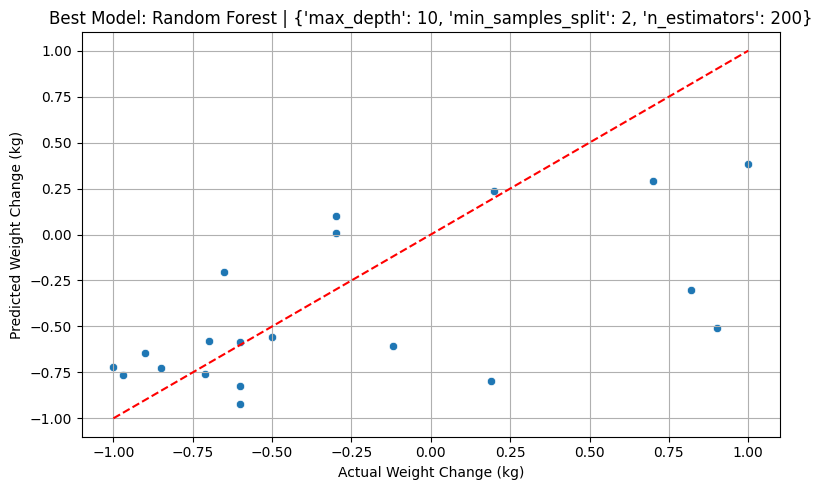

In [125]:
df["Weight_7day_change"] = df["Body Weight (kg)"].shift(-7) - df["Body Weight (kg)"]
target = 'Weight_7day_change'

features = [
    'Daily Calorie Intake',
    'Daily Protein Intake(g)',
    'Daily Carbohydrate Intake(g)',
    'Daily Fat Intake(g)',
    'Sleep Duration (hours)',
    'Exercise Time (minutes)',
    'Temperature (°C)',
    'Calorie Deficit (kcal)'
    
]

X = df[features]
y = df[target]

data_clean = pd.concat([X, y], axis=1).dropna()
X = data_clean[features]
y = data_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    "Linear Regression": [
        {"fit_intercept": [True, False]}
    ],
    "Decision Tree": [
        {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]}
    ],
    "Random Forest": [
        {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None], "min_samples_split": [2, 5]}
    ]
}

models = {
    "Linear Regression": LinearRegression,
    "Decision Tree": DecisionTreeRegressor,
    "Random Forest": RandomForestRegressor
}

results_detailed = {}

for model_name, param_list in param_grid.items():
    for params in ParameterGrid(param_list):
        model = models[model_name](**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        key = f"{model_name} | {params}"
        results_detailed[key] = {'MSE': mse, 'R²': r2}

results_df = pd.DataFrame(results_detailed).T.sort_values('R²', ascending=False)
results_df = results_df.reset_index()
results_df.columns = ['Model and Parameters', 'MSE', 'R²']

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  

print("\n📊 Top 10 Models Results (sorted by R²):")

top10_models = results_df.head(10).round(4)

top10_models = top10_models.reset_index(drop=True)

display(top10_models)

avg_r2 = results_df['R²'].mean()
max_r2 = results_df['R²'].max()
min_r2 = results_df['R²'].min()

print(f"\n📈 R² Summary:")
print(f"- Average R²: {avg_r2:.4f}")
print(f"- Best R²: {max_r2:.4f}")
print(f"- Worst R²: {min_r2:.4f}")

best_row = results_df.loc[results_df['R²'].idxmax()]
best_model_key = best_row['Model and Parameters']
best_model_name = best_model_key.split('|')[0].strip()
best_model_params = eval(best_model_key.split('|')[1].strip())

print(f"\n🏆 Best Model: {best_model_key}")

best_model = models[best_model_name](**best_model_params)
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=best_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Best Model: {best_model_name} | {best_model_params}")
plt.xlabel("Actual Weight Change (kg)")
plt.ylabel("Predicted Weight Change (kg)")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/1k/5khtm0rj03s6l0x324g20y6c0000gn/T/ipykernel_81967/76325940.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


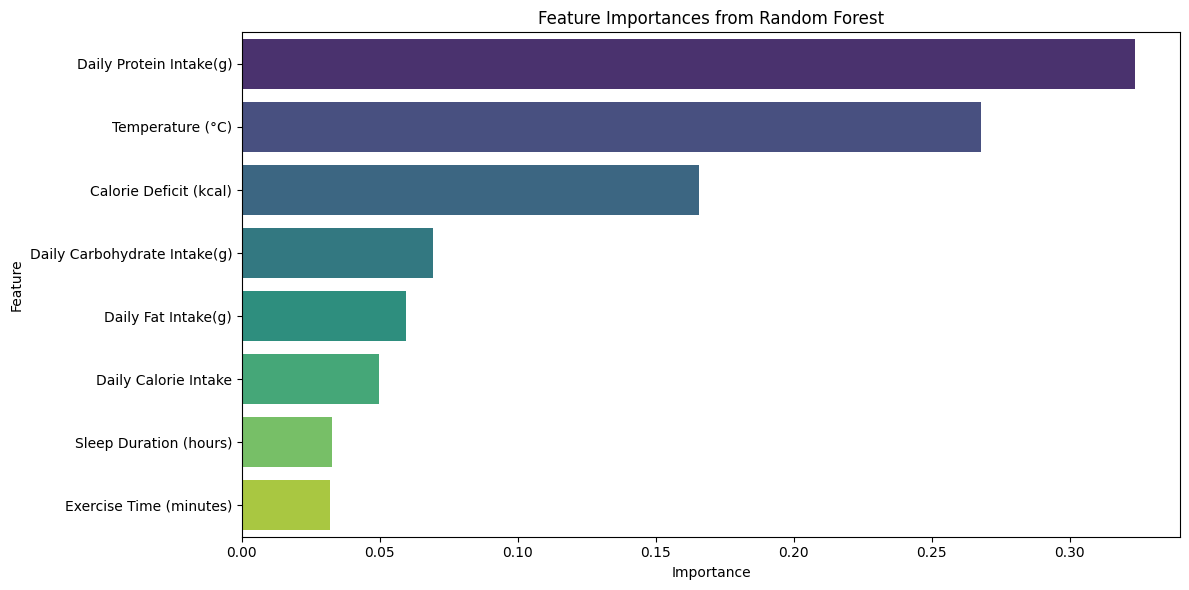

In [126]:
target = 'Weight_7day_change'

X = df[features]
y = df[target]
data_clean = pd.concat([X, y], axis=1).dropna()
X = data_clean[features]
y = data_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


The Random Forest model highlights:

➡️ Daily Protein Intake emerged as the most important factor, suggesting its key role in body composition changes.

➡️ Surprisingly, Temperature (°C) had a strong influence—indicating that external factors like weather could impact weight fluctuations.

➡️ Calorie Deficit (kcal) was also a strong predictor, partly influenced by exercise duration 